1/1 [==============================] - 4s 4s/step


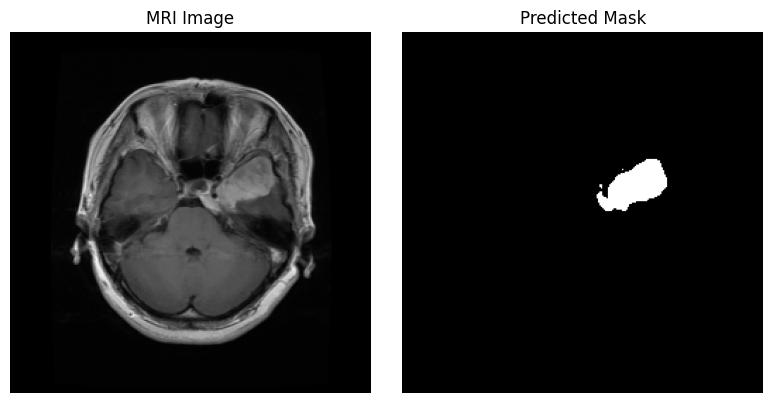

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# ===============================
# Load custom objects
# ===============================
class SafeGroupNormalization(keras.layers.Layer):
    def __init__(self, groups=8, axis=-1, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.init_groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        self.groups = min(self.init_groups, dim)
        self.gamma = self.add_weight(name="gamma", shape=(dim,), initializer="ones", trainable=True)
        self.beta  = self.add_weight(name="beta",  shape=(dim,), initializer="zeros", trainable=True)

    def call(self, x):
        input_shape = tf.shape(x)
        N, H, W, C = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        G = tf.minimum(self.groups, C)
        x = tf.reshape(x, [N, H, W, G, C // G])
        mean, var = tf.nn.moments(x, axes=[1,2,4], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        x = tf.reshape(x, [N, H, W, C])
        return self.gamma * x + self.beta

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true + y_pred)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(bce) + (1.0 - dice_coef(y_true, y_pred))


# ===============================
# Load pretrained GM-UNet model
# ===============================
model = keras.models.load_model(
    "gmunet_final.h5",   # <-- your trained model path
    custom_objects={
        "SafeGroupNormalization": SafeGroupNormalization,
        "bce_dice_loss": bce_dice_loss,
        "dice_coef": dice_coef,
        "iou_coef": iou_coef
    }
)

# ===============================
# Preprocessing function
# ===============================
IMG_SIZE = (256, 256)

def read_image(path, size=IMG_SIZE):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# ===============================
# Single MRI Prediction (No GT Mask)
# ===============================
# Change this to your test MRI path
test_img_path = "1.png"

# Preprocess
img = read_image(test_img_path)
inp = tf.expand_dims(img, axis=0)

# Predict mask
pred_mask = model.predict(inp)[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# ===============================
# Visualization
# ===============================
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("MRI Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(pred_mask), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 [==============================] - 4s 4s/step


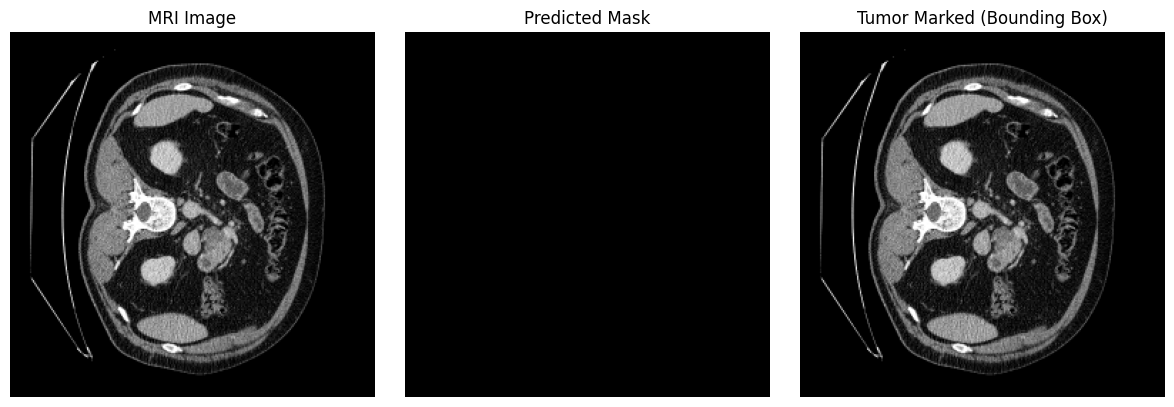

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2

# ===============================
# Custom layers & metrics
# ===============================
class SafeGroupNormalization(keras.layers.Layer):
    def __init__(self, groups=8, axis=-1, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.init_groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        self.groups = min(self.init_groups, dim)
        self.gamma = self.add_weight(name="gamma", shape=(dim,), initializer="ones", trainable=True)
        self.beta  = self.add_weight(name="beta",  shape=(dim,), initializer="zeros", trainable=True)

    def call(self, x):
        input_shape = tf.shape(x)
        N, H, W, C = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        G = tf.minimum(self.groups, C)
        x = tf.reshape(x, [N, H, W, G, C // G])
        mean, var = tf.nn.moments(x, axes=[1,2,4], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        x = tf.reshape(x, [N, H, W, C])
        return self.gamma * x + self.beta

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    total = tf.reduce_sum(y_true + y_pred)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(bce) + (1.0 - dice_coef(y_true, y_pred))

# ===============================
# Load pretrained GM-UNet model
# ===============================
model = keras.models.load_model(
    "gmunet_final.h5",
    custom_objects={
        "SafeGroupNormalization": SafeGroupNormalization,
        "bce_dice_loss": bce_dice_loss,
        "dice_coef": dice_coef,
        "iou_coef": iou_coef
    }
)

# ===============================
# Preprocessing
# ===============================
IMG_SIZE = (256, 256)

def read_image(path, size=IMG_SIZE):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# ===============================
# Prediction and Visualization
# ===============================
test_img_path = "p200.png"

# Read and predict
img = read_image(test_img_path)
inp = tf.expand_dims(img, axis=0)
pred_mask = model.predict(inp)[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# ===============================
# Bounding Box Extraction
# ===============================
mask = tf.squeeze(pred_mask).numpy()
mask_uint8 = (mask * 255).astype(np.uint8)
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_with_box = (img.numpy() * 255).astype(np.uint8).copy()

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 10 and h > 10:  # filter small noise
        cv2.rectangle(img_with_box, (x, y), (x+w, y+h), (0, 255, 0), 2)

# ===============================
# Plot results
# ===============================
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("MRI Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_with_box)
plt.title("Tumor Marked (Bounding Box)")
plt.axis("off")

plt.tight_layout()
plt.show()
